In [4]:
import festim as F
import fenics as f
import h_transport_materials as htm
import numpy as np
from scipy.optimize import curve_fit
import itertools

In [5]:
# Nickel material properties and dimensions
nickel_diffusivity = htm.diffusivities.filter(material=htm.NICKEL).mean()
nickel_solubility = htm.solubilities.filter(material=htm.NICKEL).mean()
nickel_permeability = htm.permeabilities.filter(material=htm.NICKEL).mean()
nickel_length = 2e-3 # in m

nickel = F.Material(
    id=1,
    D_0 = nickel_diffusivity.pre_exp.magnitude,
    E_D = nickel_diffusivity.act_energy.magnitude,
    S_0 = nickel_solubility.pre_exp.magnitude,
    E_S = nickel_solubility.act_energy.magnitude,
)



In [6]:
# FLiBe material properties and dimensions
flibe_diffusivity = htm.diffusivities.filter(material=htm.FLIBE, author='calderoni')[0]
flibe_solubility = htm.solubilities.filter(material=htm.FLIBE, author='calderoni')[0]
flibe_permeability = htm.permeabilities.filter(material=htm.FLIBE).mean()
flibe_length = 8e-3

flibe = F.Material(
    id=1,
    D_0=flibe_diffusivity.pre_exp.magnitude,
    E_D=flibe_diffusivity.act_energy.magnitude,
    S_0 = flibe_solubility.pre_exp.magnitude,
    E_S = flibe_solubility.act_energy.magnitude,
)

In [7]:
# Building and running the nickel model
nickel_model = F.Simulation()

# 2mm thick mesh
nickel_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, nickel_length, num=1001)
)
nickel_model.materials = nickel
nickel_model.T = F.Temperature(value=973)

P_up = 101325  # Pa

nickel_model.boundary_conditions = [
    F.SievertsBC(surfaces=1, S_0=nickel.S_0, E_S=nickel.E_S, pressure=P_up),
    F.DirichletBC(surfaces=2, value=0, field=0)
]

nickel_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    final_time=1 * 3600 # s
    )

nickel_model.dt = F.Stepsize(initial_value=10, stepsize_change_ratio=1.1)

derived_quantities = F.DerivedQuantities([F.HydrogenFlux(surface=2)])

folder = "1D_model"
nickel_model.exports = [
        F.XDMFExport(field="solute", filename=f"{folder}/nickel_concentration.xdmf", checkpoint=False),
        derived_quantities,
    ]

In [8]:
# Running the model

nickel_model.initialise()
nickel_model.run()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-t

/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        3.6e+03 s    Elapsed time so far: 13.5 s


In [9]:
# Defining the downstream flux for salt and metal

def downstream_flux_salt(t, P_up, L, permeability, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up * permeability / L * (2*summation + 1)

def downstream_flux_metal(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): material permeability
        L (float): material thickness
        D (float): diffusivity of H in the material

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up**0.5 * permeability / L * (2*summation + 1)

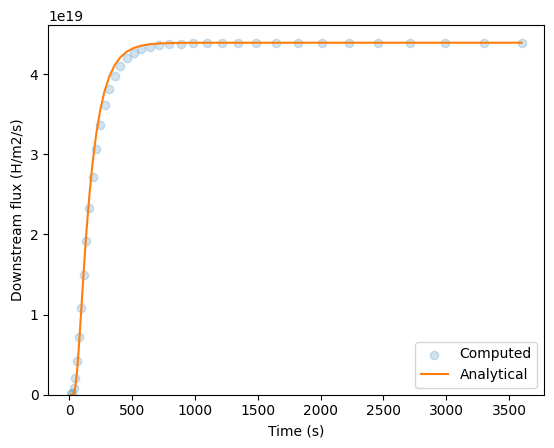

In [10]:
# Plotting the model and the analytical solution
times = derived_quantities.t
computed_flux = derived_quantities.filter(surfaces=2).data

import matplotlib.pyplot as plt
T = 973.15 * htm.ureg.K
plt.scatter(times, np.abs(computed_flux), alpha=0.2, label="Computed")
plt.plot(times, downstream_flux_metal(times * htm.ureg.sec, P_up * htm.ureg.Pa,
                                permeability=nickel_diffusivity.value(T)*nickel_solubility.value(T), 
                                L=nickel_length*htm.ureg.m, D=nickel_diffusivity.value(T)), color="tab:orange", label="Analytical")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.show()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        2.2e+04 s    Elapsed time so far: 3.8 s
props [3.23109478e+12 5.08082685e-09]
real (3256434971703.789, 5.176719796581502e-09)


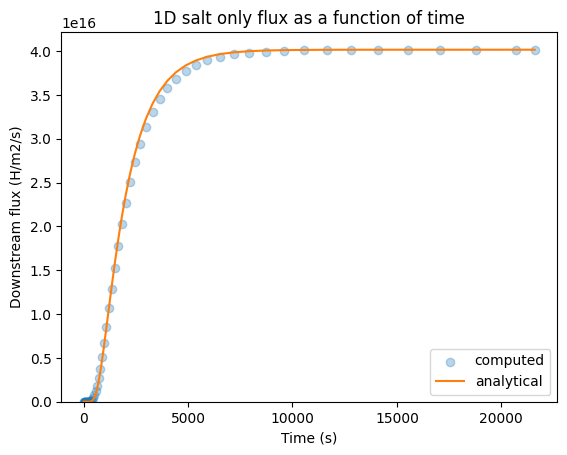

In [11]:
# Building, running, and plotting the flibe model
# Building and running the nickel model
flibe_model = F.Simulation()

flibe_length = 8.1e-3
# 20mm thick mesh
flibe_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, flibe_length, num=1001)
)
flibe_model.materials = flibe
flibe_model.T = F.Temperature(value=973)

P_up = 100  # Pa

flibe_model.boundary_conditions = [
    F.HenrysBC(surfaces=1, H_0=flibe.S_0, E_H=flibe.E_S, pressure=P_up),
    F.DirichletBC(surfaces=2, value=0, field=0)
]

flibe_model.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    final_time=6 * 3600 # s
    )

flibe_model.dt = F.Stepsize(initial_value=10, stepsize_change_ratio=1.1)
flibe_derived_quantities = F.DerivedQuantities([F.HydrogenFlux(surface=2)])
flibe_model.exports = [
        F.XDMFExport(field="solute", filename=f"{folder}/flibe_concentration.xdmf", checkpoint=False),
        flibe_derived_quantities,
    ]
flibe_model.initialise()
flibe_model.run()

times = flibe_derived_quantities.t
flibe_computed_flux = flibe_derived_quantities.filter(surfaces=2).data

# Checking curve fit works for regular data
guess = (flibe_diffusivity.value(T).magnitude*flibe_solubility.value(T).magnitude, flibe_diffusivity.value(T).magnitude)
props, cov = curve_fit(lambda t, permeability, D: downstream_flux_salt(t, P_up, flibe_length, permeability, D), times, np.abs(flibe_computed_flux), guess)
print('props', props)
print('real', guess)


T = flibe_model.T.value * htm.ureg.K
plt.scatter(times, np.abs(flibe_computed_flux), alpha=0.3, label="computed")
plt.plot(times, downstream_flux_salt(times * htm.ureg.sec, P_up * htm.ureg.Pa,
                                permeability=flibe_diffusivity.value(T)*flibe_solubility.value(T), 
                                L=flibe_length*htm.ureg.m, D=flibe_diffusivity.value(T)), color="tab:orange", label="analytical")
plt.ylim(bottom=0)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")
plt.title("1D salt only flux as a function of time")
####plt.savefig('/Users/jaron/Downloads/1d_one_mat.svg')
plt.show()

In [12]:
# Adding in nickel as a permeation barrier, method from task04
# Changing material IDs and assigning borders

# Adjusting parameters for the Calderoni experiment

flibe_length = 8.1e-3
P_up = 100
nickel_length = 2e-3

nickel.borders = [0, nickel_length]

flibe.borders = [nickel_length, nickel_length + flibe_length]
flibe.id = 2
flibe.solubility_law = "henry"

model_barrier = F.Simulation()
model_barrier.materials = [nickel, flibe]

vertices_bottom = np.linspace(0, nickel_length, num = 500)
vertices_top = np.linspace(nickel_length, nickel_length + flibe_length, num = 500)
vertices = np.concatenate([vertices_bottom, vertices_top])

model_barrier.mesh = F.MeshFromVertices(vertices)

model_barrier.T = F.Temperature(973)

bottom_bc = F.SievertsBC(
    surfaces=1,
    S_0=nickel.S_0,
    E_S=nickel.E_S,
    pressure = P_up
)

# Assuming zero concentration on the top surface
top_bc = F.DirichletBC(
    field="solute",
    surfaces=2,
    value=0
)

model_barrier.boundary_conditions = [bottom_bc, top_bc]

derived_quantities_with_barrier = F.DerivedQuantities([F.HydrogenFlux(surface=2)])
txt_export = F.TXTExport(
    field='solute',
    filename=f"{folder}/barrier_concentration.txt", 
    times = [0.1*3600,0.2*3600,1*3600, 6*3600])
model_barrier.exports = [
        F.XDMFExport(field="solute", filename=f"{folder}/barrier_concentration.xdmf", checkpoint=False),
        derived_quantities_with_barrier,
        txt_export
    ]

model_barrier.settings = F.Settings(
    absolute_tolerance=1e8,
    relative_tolerance=1e-10,
    final_time=8*3600, # 6 hours
    chemical_pot=True,
)

model_barrier.dt = F.Stepsize(
    initial_value=10,
    stepsize_change_ratio=1.1,
)

In [13]:
# Running the model
model_barrier.initialise()
model_barrier.run()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining initial values
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
Calling FFC just-in-time (JIT) compiler, this may take some time.


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Calling FFC just-in-time (JIT) compiler, this may take some time.
100.0 %        2.9e+04 s    Elapsed time so far: 20.0 s


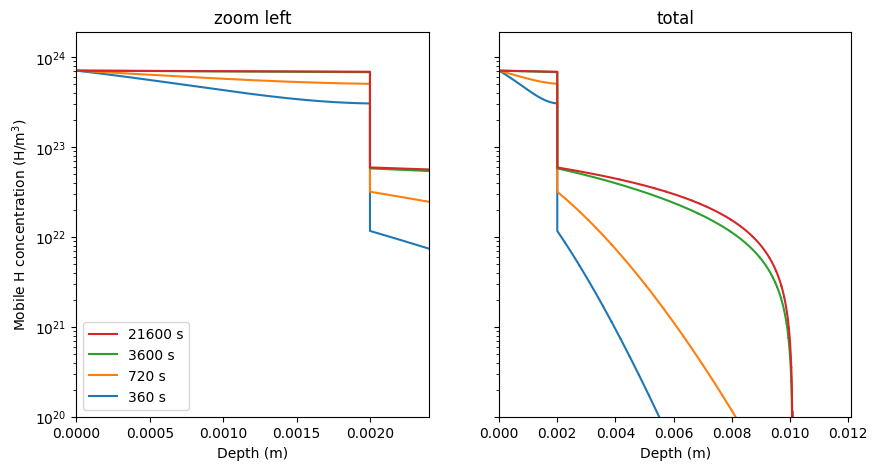

In [14]:
# Plotting concentration as a function of depth at various times
# Method derived from task04

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
data = np.genfromtxt(folder + f"/barrier_concentration.txt", skip_header=1, delimiter=",")
data = data[data[:, 0].argsort()]  # make sure data is sorted

xlim_left = (0, nickel_length * 1.2)
xlim_right = (0, (nickel_length + flibe_length) * 1.2)

for ax, xlim in zip(
    axs,
    [xlim_left, xlim_right],
):
    plt.sca(ax)
    for i, time in enumerate(txt_export.times):
        plt.plot(data[:, 0], data[:, i + 1], label=f"{time:.0f} s")

    plt.xlabel("Depth (m)")
    plt.xlim(*xlim)

axs[0].set_yscale("log")
axs[0].set_ylim(bottom=1e20)
axs[0].set_ylabel("Mobile H concentration (H/m$^3$)")
axs[0].set_title("zoom left")
axs[1].set_title("total")
axs[0].legend(reverse=True)
#plt.savefig("/Users/jaron/Downloads/concentration_depth.svg")
plt.show()

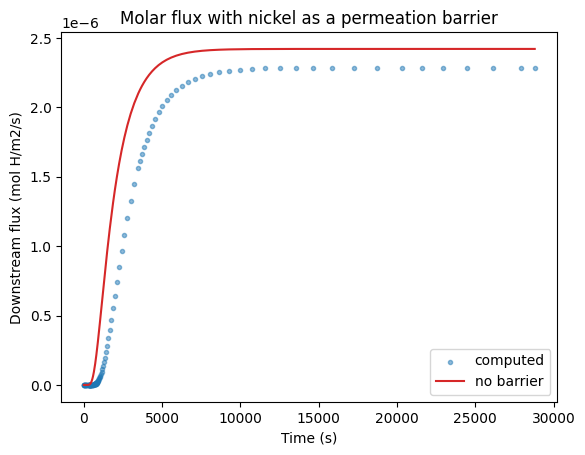

In [15]:
# Plotting the model and the analytical solution to the flibe
times = derived_quantities_with_barrier.t
barrier_computed_flux = derived_quantities_with_barrier.filter(surfaces=2).data
N_A = 6.022e-23

T = 973.15 * htm.ureg.K
plt.figure()
plt.scatter(times, np.abs(barrier_computed_flux)*N_A, alpha=0.5, label="computed", marker = ".")

plt.plot(times, downstream_flux_salt(times * htm.ureg.sec, P_up * htm.ureg.Pa,
                                permeability=flibe_diffusivity.value(T)*flibe_solubility.value(T), 
                                L=flibe_length*htm.ureg.m, D=flibe_diffusivity.value(T))*N_A, color="tab:red", label="no barrier")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (mol H/m2/s)")
plt.title("Molar flux with nickel as a permeation barrier")
plt.show()

### Now to figure out the error from the boundary
The plan:
- Figure out a curve fit and have it extract the permeability and the diffusivity and thus the solubility
- calculate the error between the analytical props and the actual props (comparing it down downstream flux of flibe only)
    - bc if negligible then we dont care about nickel and only care about flibe
- run a bunch of simulations with various params
- plot the error as a function of the params
- 3d plot/gradient of error as the z and pressure/thickness as x/y
    - probably have to 3d interpolate values or something to get a smooth gradient

diff calderoni 5.176719796581502e-09 meter ** 2 / second
sol 6.290537443912278e+20 particle / meter ** 3 / pascal
diff calc 3.324139877854815e-09
perm calc 3125393937638.895
perm calderoni 3256434971703.789
sol calc 9.402113185609452e+20
sol calderoni 6.290537443912278e+20
diff error 35.786752838159344
perm error 4.024064205290501
sol error 49.46438630149842
3125393937638.895 3.324139877854815e-09


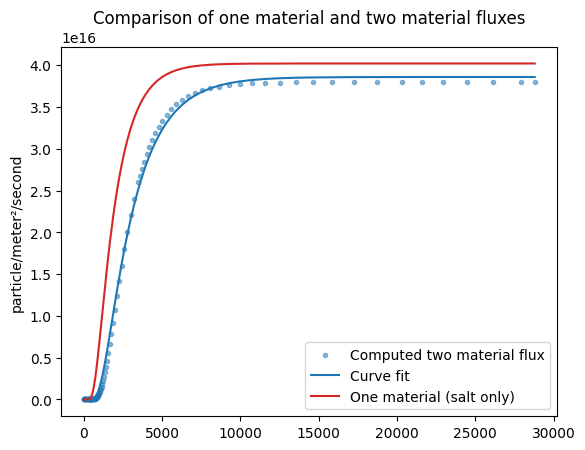

In [16]:
from scipy.optimize import curve_fit
#print(times)
#print(np.abs(barrier_computed_flux))

# Proof of concept
guess = (3157333279361, 5.090185116256628e-09)
props, cov = curve_fit(lambda t, permeability, D: downstream_flux_salt(t, P_up, flibe_length, permeability, D), times, np.abs(barrier_computed_flux), guess)
plt.scatter(times, np.abs(barrier_computed_flux), alpha=0.5, label="Computed two material flux", marker = ".")
plt.plot(times, downstream_flux_salt(times, P_up, flibe_length, *props), label="Curve fit")
plt.plot(times, downstream_flux_salt(times * htm.ureg.sec, P_up * htm.ureg.Pa, L=flibe_length*htm.ureg.m, permeability=flibe_diffusivity.value(T)*flibe_solubility.value(T), D=flibe_diffusivity.value(T)), color="tab:red", label="One material (salt only)")
plt.legend()
perm=flibe_diffusivity.value(T).magnitude*flibe_solubility.value(T).magnitude
sol = props[0]/props[1]

print("diff calderoni", flibe_diffusivity.value(T))
print("sol", flibe_solubility.value(T))
print("diff calc", props[1])
print("perm calc", props[0])
print("perm calderoni", perm)
print("sol calc", sol)
print("sol calderoni", flibe_solubility.value(T).magnitude)
diff_error = np.abs(flibe_diffusivity.value(T).magnitude - props[1])/flibe_diffusivity.value(T).magnitude*100
print("diff error", diff_error)
perm_error = np.abs(perm - props[0])/perm*100
print("perm error", perm_error)
sol_error = np.abs(flibe_solubility.value(T).magnitude - sol)/flibe_solubility.value(T).magnitude*100
print("sol error", sol_error)

plt.title("Comparison of one material and two material fluxes")
plt.savefig('/Users/jaron/Downloads/1d_two_mat.svg')
print(*props)

Now wrapping the above cells in functions for improved functionality

### Make model function

In [17]:
def make_model(nickel_length, flibe_length, temp, P_up, folder = '1D_model'):
    '''
    Function to make 1D festim model
    nickel_length: length of nickel in [meters]
    flibe_length: length of flibe [meters]
    temp: temp of experiment [Kelvin]
    P_up: upstream hydrogen partial pressure [Pa]
    
    Runs the model and returns the derived_quantities object of the model
    '''
    nickel.borders = [0, nickel_length]
    flibe.borders = [nickel_length, nickel_length + flibe_length]
    model = F.Simulation()
    model.materials = [nickel, flibe]
    vertices_bottom = np.linspace(0, nickel_length, num = 500)
    vertices_top = np.linspace(nickel_length, nickel_length + flibe_length, num = 500)
    vertices = np.concatenate([vertices_bottom, vertices_top])
    model.mesh = F.MeshFromVertices(vertices)
    model.T = F.Temperature(temp)

    bottom_bc = F.SievertsBC(
        surfaces=1,
        S_0=nickel.S_0,
        E_S=nickel.E_S,
        pressure = P_up
    )

    # Assuming zero concentration on the top surface
    top_bc = F.DirichletBC(
        field="solute",
        surfaces=2,
        value=0
    )

    model.boundary_conditions = [bottom_bc, top_bc]

    derived_quantities = F.DerivedQuantities([F.HydrogenFlux(surface=2)])
    txt_export = F.TXTExport(
        field='solute',
        filename=f"{folder}/barrier_concentration.txt", 
        times = [0.1*3600,0.2*3600,1*3600, 6*3600])
    
    model.exports = [
        F.XDMFExport(field="solute", filename=f"{folder}/barrier_concentration.xdmf", checkpoint=False),
        derived_quantities,
        txt_export
    ]
    model.settings = F.Settings(
        absolute_tolerance=1e8,
        relative_tolerance=1e-10,
        final_time=20*3600, # 8 hours
        chemical_pot=True,
    )
    
    model.dt = F.Stepsize(
        initial_value=10,
        stepsize_change_ratio=1.1,
    )

    model.initialise()
    model.run() 

    return derived_quantities

In [18]:
model = make_model(nickel_length, flibe_length, T.magnitude, P_up)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s


### Plot model function

In [19]:
# Function for plotting the values

def plot_concentration(model, nickel_length, flibe_length, temp, P_up, depth=True, time = True):
    '''
    Function for plotting concentration as a function of depth and flux at the top
    surface as a function of time
    model: a model created from the make_model function
    nickel_length: length of nickel [meters]
    flibe_length: length of flibe [meters]
    temp: temperature of experiment [Kelvin]
    P_up: upstream hydrogen partial pressure [Pa]
    depth: give depth graph
    time: give time graph

    '''
    if depth:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
        data = np.genfromtxt(folder + f"/barrier_concentration.txt", skip_header=1, delimiter=",")
        data = data[data[:, 0].argsort()]  # make sure data is sorted

        xlim_left = (0, nickel_length * 1.2)
        xlim_right = (0, (nickel_length + flibe_length) * 1.2)

        for ax, xlim in zip(
            axs,
            [xlim_left, xlim_right],
        ):
            plt.sca(ax)
            for i, time in enumerate(txt_export.times):
                plt.plot(data[:, 0], data[:, i + 1], label=f"{time:.0f} s")

            plt.xlabel("Depth (m)")
            plt.xlim(*xlim)

        axs[0].set_yscale("log")
        axs[0].set_ylim(bottom=1e20)
        axs[0].set_ylabel("Mobile H concentration (H/m$^3$)")
        axs[0].set_title("zoom left")
        axs[1].set_title("total")
        axs[0].legend(reverse=True)
        plt.show()

    if time:
        times = model.t
        barrier_computed_flux = model.filter(surfaces=2).data

        T = temp * htm.ureg.K
        plt.figure()
        plt.scatter(times, np.abs(barrier_computed_flux), alpha=0.5, label="computed", marker = ".")

        plt.plot(times, downstream_flux_salt(times * htm.ureg.sec, P_up * htm.ureg.Pa,
                                        permeability=flibe_diffusivity.value(T)*flibe_solubility.value(T), 
                                        L=flibe_length*htm.ureg.m, D=flibe_diffusivity.value(T)), color="tab:red", label="no barrier")
        plt.legend()
        plt.xlabel("Time (s)")
        plt.ylabel("Downstream flux (mol H/m2/s)")
        plt.title("Molar flux with nickel as a permeation barrier")
        plt.show()
    return

### Error calculation

In [20]:
# Function for fitting the curve and giving the errors of the expected vs barrier

def prop_errors(model, flibe_length, temp, P_up, plot = False, label = None):
    '''
    Function for quantifying the error between the observed properties and the properties
    that are calculated with the barrier

    Returns a dictionary of "diffusivity error", "solubility error", and "permeability error"

    model: a model created with the make_model function
    flibe_length: the length of flibe [meters]
    temp: the temperature of the experiment [Kelvin]
    plot: plot the data and the fitted curve
    label: a string that adds a label to the legend of the plot
    '''
    # Providing a guess for the curve_fit function, which is the (measured perm, measured diff)
    guess = (flibe_solubility.value(temp).magnitude*flibe_diffusivity.value(temp).magnitude, flibe_diffusivity.value(temp).magnitude)

    computed_flux = model.filter(surfaces=2).data
    times = model.t

    # Using a lambda function so that the length and the pressure are not being fit
    props, cov = curve_fit(lambda t, permeability, D: downstream_flux_salt(t, P_up, flibe_length, permeability, D), times, np.abs(computed_flux), guess)    

    # The calculated solubility and permeability
    perm = flibe_diffusivity.value(temp).magnitude * flibe_solubility.value(temp).magnitude
    sol = props[0]/props[1]

    # The error calculations
    diff_error = np.abs(flibe_diffusivity.value(temp).magnitude - props[1])/flibe_diffusivity.value(temp).magnitude*100
    sol_error = np.abs(flibe_solubility.value(temp).magnitude - sol)/flibe_solubility.value(temp).magnitude*100
    perm_error = np.abs(perm - props[0])/perm*100


    # Plotting functionality
    if plot:
        # Having each simulation have the same color on the plot
        marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', '8', 'p'))
        line=plt.plot(times, downstream_flux_salt(times, P_up, flibe_length, *props), linestyle='', markeredgecolor='none', marker=next(marker))
        linecolor = line[0].get_color()

        # Constructing the plots
        plt.scatter(times, np.abs(computed_flux), alpha=0.3, label=f"Computed flux ({label})", marker = ".", color=linecolor)
        plt.plot(times, downstream_flux_salt(times, P_up, flibe_length, *props), label=f"Curve fit ({label})", linestyle = "dashed", color=linecolor)
        plt.plot(times, downstream_flux_salt(times * htm.ureg.sec, P_up * htm.ureg.Pa,permeability=flibe_diffusivity.value(temp)*flibe_solubility.value(temp), L=flibe_length*htm.ureg.m, D=flibe_diffusivity.value(temp)), label=f"No barrier ({label})", color=linecolor)
        plt.legend()
    return {"diffusivity error": diff_error, "solubility error": sol_error, "permeability error": perm_error }

In [21]:
# Setting up a for loop to sweep through various temperatures and plot the fluxes

nickel_length = 2e-3
flibe_length = 8.1e-3
Pressures = np.linspace(100, 1000, num = 10)
temp = 900
lengths = np.linspace(2e-3, 20e-3, num = 10)

'''
for flibe_length in lengths:
    model = make_model(nickel_length, flibe_length, temp, P_up)
    #plot_concentration(model, nickel_length, flibe_length, temp, P_up, depth=False)
    #print("the errors are", prop_errors(model, flibe_length, temp, P_up, label = str(flibe_length) + "m"))
    errs.append(prop_errors(model, flibe_length, temp, P_up)['diffusivity error'])

plt.plot(lengths, errs)
plt.hlines(10, lengths[0], lengths[-1])
plt.show()
'''
"""
errs=[]
for P_up in Pressures:
    model = make_model(nickel_length, flibe_length, temp, P_up)
    errs.append(prop_errors(model, flibe_length, temp, P_up)['diffusivity error'])
"""

overall = []

for P_up in Pressures:
    errs = []
    for flibe_length in lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['diffusivity error'])
    overall.append(errs)






Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s


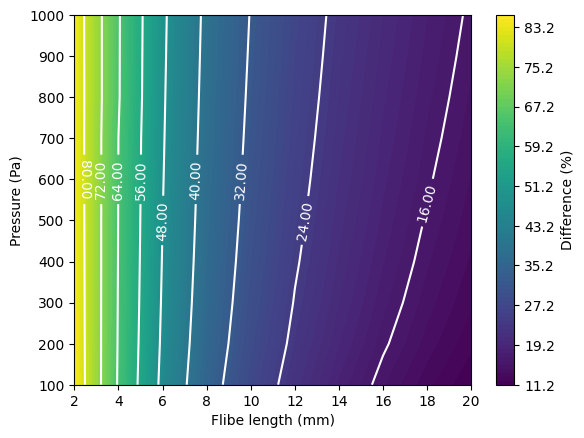

In [22]:
# Attempting to make a contour

XX, YY = np.meshgrid(lengths*1000, Pressures)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Flibe length (mm)")
plt.ylabel("Pressure (Pa)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')
#plt.title("Diffusivity error by varying pressure and flibe length at given temp")
plt.savefig('/Users/jaron/Downloads/pressure_flibe_diff.svg')
plt.show()

In [23]:
# Simulations comparing temperature and flibe length
temps = np.linspace(500+273, 700+273, num = 10)
nickel_length = 2e-3
P_up = 100

overall = []

for temp in temps:
    errs = []
    for flibe_length in lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['diffusivity error'])
    overall.append(errs)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s


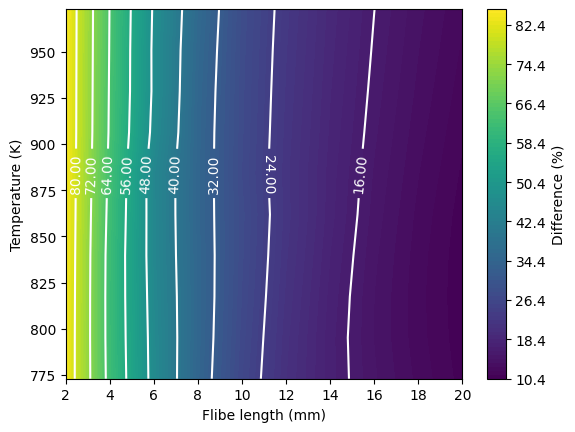

In [24]:
XX, YY = np.meshgrid(lengths*1000, temps)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Flibe length (mm)")
plt.ylabel("Temperature (K)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Diffusivity error by varying temperature and flibe length at given pressure")
plt.savefig('/Users/jaron/Downloads/temperature_flibe_diff.svg')
plt.show()

In [25]:
# Simulations comparing pressure and nickel length
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)
Pressures = np.linspace(100, 1000, num = 10)
flibe_length = 8e-3
temp = 900

overall = []

for P_up in Pressures:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['diffusivity error'])
    overall.append(errs)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s


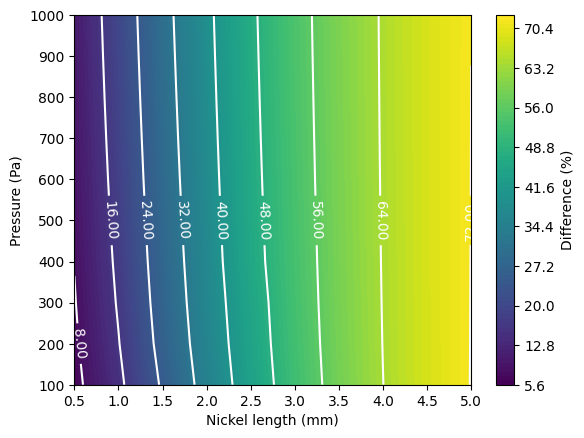

In [26]:
XX, YY = np.meshgrid(nickel_lengths*1000, Pressures)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 8, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Pressure (Pa)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Diffusivity error by varying pressure and nickel length at given temp")
plt.savefig('/Users/jaron/Downloads/pressure_nickel_diff.svg')
plt.show()

In [27]:
# Simulations comparing temperature and nickel length
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)
flibe_length = 8e-3
temps = np.linspace(500+273, 700+237, num = 10)
P_up = 100

overall = []

for temp in temps:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['diffusivity error'])
    overall.append(errs)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/generic_simulation.py:398: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/h_transport_materials/property.py:419: UserWarning: no units were given with T, assuming kelvin
  warnings.warn(f"no units were given with T, assuming {ureg.K}")
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s


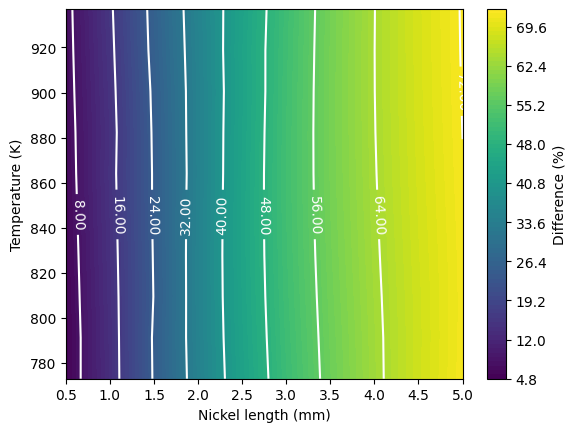

In [28]:
XX, YY = np.meshgrid(nickel_lengths*1000, temps)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Temperature (K)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Diffusivity error by varying temperature and nickel length at given pressure")
plt.savefig('/Users/jaron/Downloads/temperature_nickel_diff.svg')
plt.show()

In [29]:
# Varying nickel length and flibe length
flibe_lengths = np.linspace(2e-3, 20e-3, num = 10)
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)

temps = 900
P_up = 100

overall = []

for flibe_length in flibe_lengths:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['diffusivity error'])
    overall.append(errs)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s


/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s


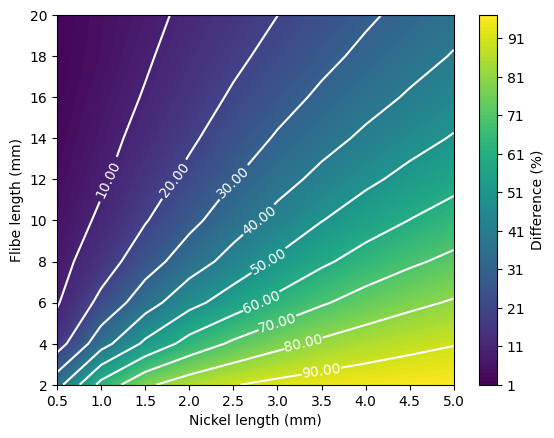

In [30]:
XX, YY = np.meshgrid(nickel_lengths*1000, flibe_lengths*1000)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Flibe length (mm)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Diffusivity error by varying flibe length and nickel length at given pressure and temperature")
plt.savefig('/Users/jaron/Downloads/flibe_nickel_diff.svg')
plt.show()

In [31]:
# Varying temp and pressure
flibe_length = 8e-3
nickel_length = 2e-3

temps = np.linspace(500+273, 700+273, num = 10)
Pressures = np.linspace(100, 1000, num = 10)

overall = []

for P_up in Pressures:
    errs = []
    for temp in temps:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['diffusivity error'])
    overall.append(errs)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s


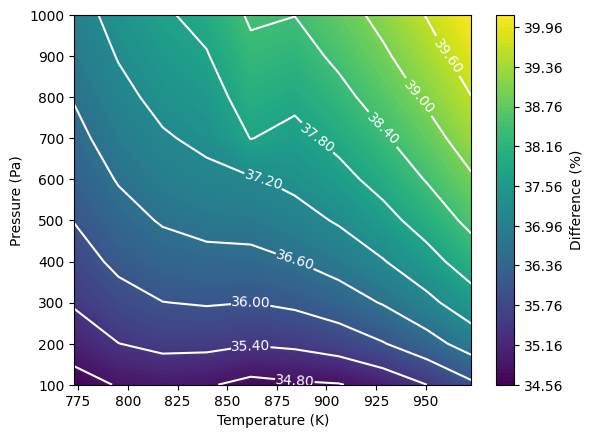

In [32]:
XX, YY = np.meshgrid(temps, Pressures)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (Pa)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Diffusivity error by varying pressure and temperature at given lengths")
plt.savefig('/Users/jaron/Downloads/pressure_temp_diff.svg')
plt.show()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s


/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_7523/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s


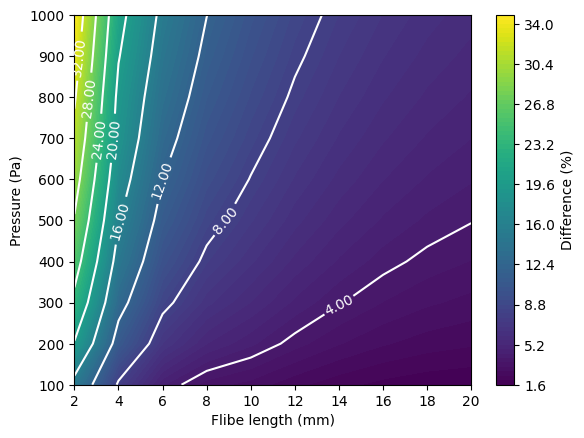

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s


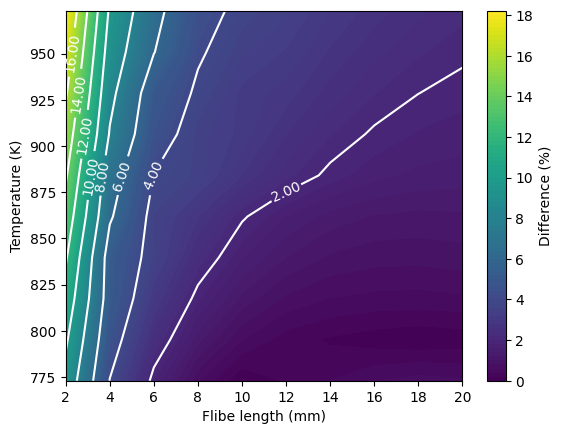

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 6.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 6.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 6.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 6.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 6.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 6.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 6.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 7.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s


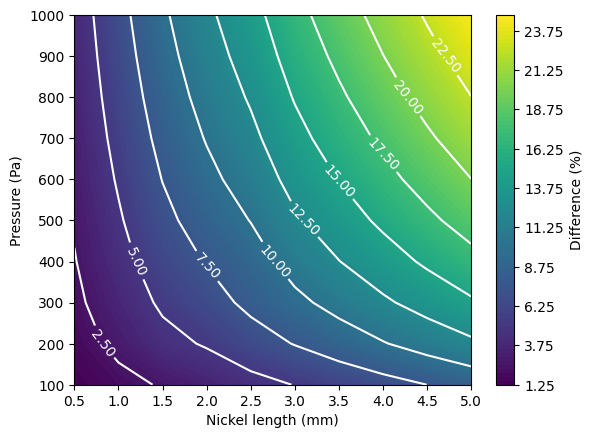

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s


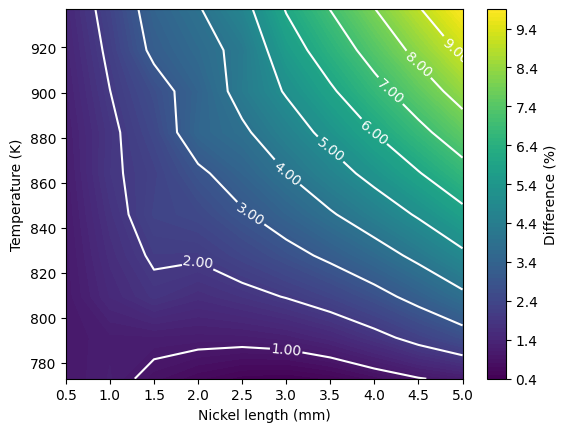

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s


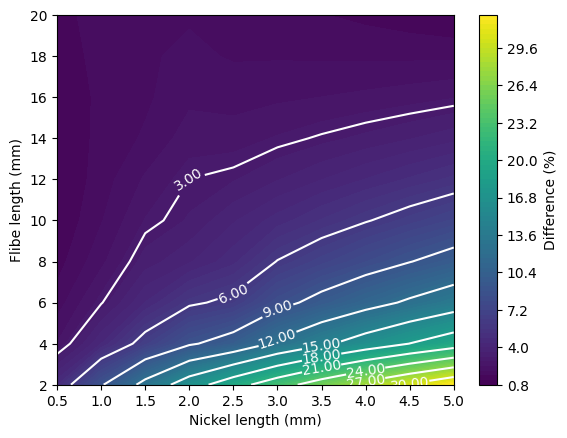

In [34]:
# Running all the previous simulations for permeability error

nickel_length = 2e-3
flibe_length = 8.1e-3
Pressures = np.linspace(100, 1000, num = 10)
temp = 900
lengths = np.linspace(2e-3, 20e-3, num = 10)
overall = []

for P_up in Pressures:
    errs = []
    for flibe_length in lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['permeability error'])
    overall.append(errs)

XX, YY = np.meshgrid(lengths*1000, Pressures)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Flibe length (mm)")
plt.ylabel("Pressure (Pa)")


#plt.title("Permeability error by varying pressure and flibe length at given temp")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

plt.savefig('/Users/jaron/Downloads/pressure_flibe_perm.svg')
plt.show()

# Simulations comparing temperature and flibe length
lengths = np.linspace(2e-3, 20e-3, num = 10)
temps = np.linspace(500+273, 700+273, num = 10)
nickel_length = 2e-3
P_up = 100

overall = []

for temp in temps:
    errs = []
    for flibe_length in lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['permeability error'])
    overall.append(errs)

XX, YY = np.meshgrid(lengths*1000, temps)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Flibe length (mm)")
plt.ylabel("Temperature (K)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Permeability error by varying temperature and flibe length at given pressure")
plt.savefig('/Users/jaron/Downloads/temp_flibe_perm.svg')
plt.show()

# Simulations comparing pressure and nickel length
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)
Pressures = np.linspace(100, 1000, num = 10)
flibe_length = 8e-3
temp = 900

overall = []

for P_up in Pressures:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['permeability error'])
    overall.append(errs)

XX, YY = np.meshgrid(nickel_lengths*1000, Pressures)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Pressure (Pa)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Permeability error by varying pressure and nickel length at given temp")
plt.savefig('/Users/jaron/Downloads/pressure_nickel_perm.svg')
plt.show()

# Simulations comparing temperature and nickel length
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)
flibe_length = 8e-3
temps = np.linspace(500+273, 700+237, num = 10)
P_up = 100

overall = []

for temp in temps:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['permeability error'])
    overall.append(errs)

XX, YY = np.meshgrid(nickel_lengths*1000, temps)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Temperature (K)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Permeability error by varying temperature and nickel length at given pressure")
plt.savefig('/Users/jaron/Downloads/temp_nickel_perm.svg')
plt.show()

# Varying nickel length and flibe length
flibe_lengths = np.linspace(2e-3, 20e-3, num = 10)
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)

temps = 900
P_up = 100

overall = []

for flibe_length in flibe_lengths:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['permeability error'])
    overall.append(errs)

XX, YY = np.meshgrid(nickel_lengths*1000, flibe_lengths*1000)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Flibe length (mm)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Permeability error by varying flibe length and nickel length at given pressure and temperature")
plt.savefig('/Users/jaron/Downloads/flibe_nickel_perm.svg')
plt.show()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 5.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s


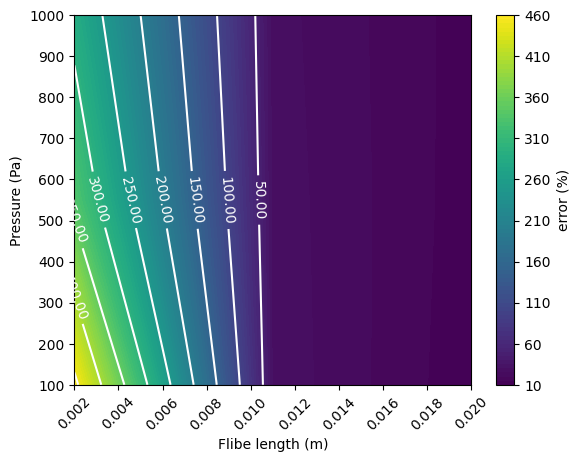

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.6 s


/var/folders/dt/l0hsmflj2bl2gdtj0z64vvph0000gn/T/ipykernel_20929/4115638926.py:17: RuntimeWarning: overflow encountered in exp
  summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 2.6 s


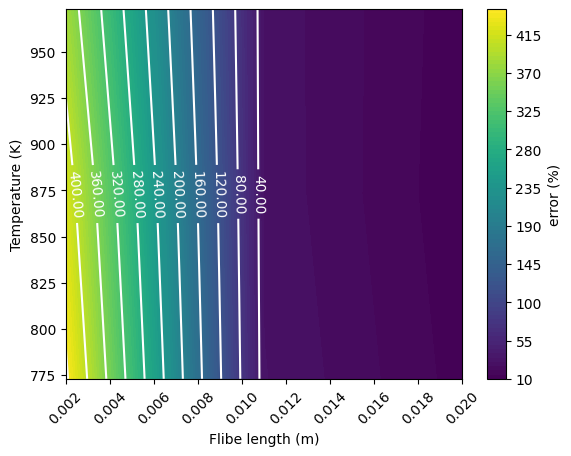

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.3 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s


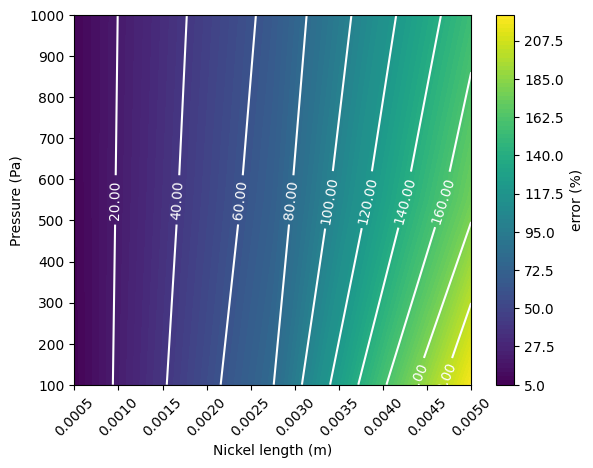

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.8 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s


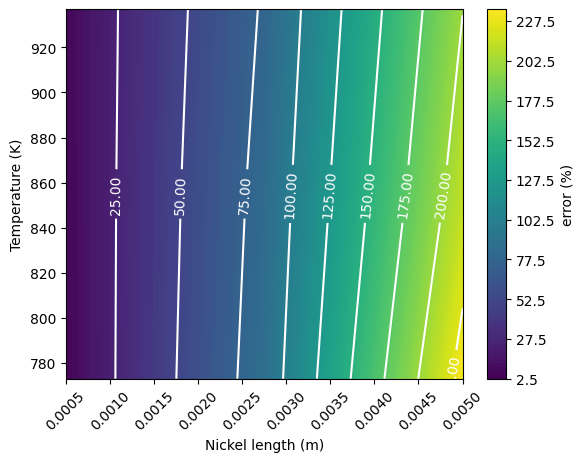

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.5 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.0 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.2 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.7 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.1 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.4 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 3.9 s
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/opt/anaconda3/envs/festim-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:129: DeprecationWarning: The current derived_quantities title style will be deprecated in a future release, please use show_units=True instead
  warnings.warn(


100.0 %        7.2e+04 s    Elapsed time so far: 4.2 s


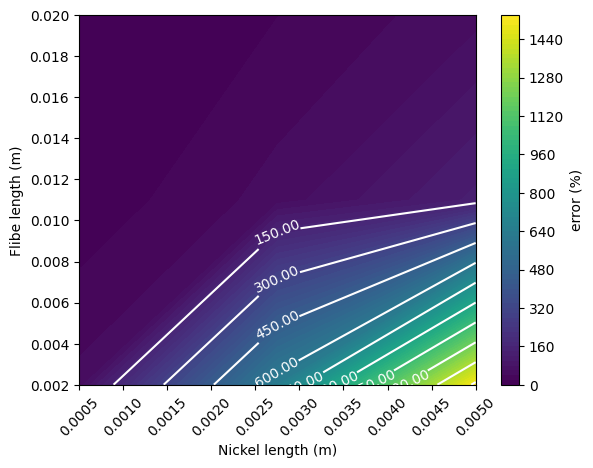

In [ ]:
# Running all the previous simulations for solubility error

nickel_length = 2e-3
flibe_length = 8.1e-3
Pressures = np.linspace(100, 1000, num = 10)
temp = 900
lengths = np.linspace(2e-3, 20e-3, num = 10)
overall = []

for P_up in Pressures:
    errs = []
    for flibe_length in lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['solubility error'])
    overall.append(errs)

XX, YY = np.meshgrid(lengths*1000, Pressures)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Flibe length (mm)")
plt.ylabel("Pressure (Pa)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Solubility error by varying pressure and flibe length at given temperature")
plt.savefig('/Users/jaron/Downloads/pressure_flibe_sol.svg')
plt.show()

# Simulations comparing temperature and flibe length
lengths = np.linspace(2e-3, 20e-3, num = 10)
temps = np.linspace(500+273, 700+273, num = 10)
nickel_length = 2e-3
P_up = 100

overall = []

for temp in temps:
    errs = []
    for flibe_length in lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['solubility error'])
    overall.append(errs)

XX, YY = np.meshgrid(lengths*1000, temps)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Flibe length (mm)")
plt.ylabel("Temperature (K)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Solubility error by varying temperature and flibe length at given pressure")
plt.savefig('/Users/jaron/Downloads/temp_flibe_sol.svg')
plt.show()

# Simulations comparing pressure and nickel length
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)
Pressures = np.linspace(100, 1000, num = 10)
flibe_length = 8e-3
temp = 900

overall = []

for P_up in Pressures:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['solubility error'])
    overall.append(errs)

XX, YY = np.meshgrid(nickel_lengths*1000, Pressures)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Pressure (Pa)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Solubility error by varying pressure and nickel length at given temp")
plt.savefig('/Users/jaron/Downloads/pressure_nickel_sol.svg')
plt.show()

# Simulations comparing temperature and nickel length
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)
flibe_length = 8e-3
temps = np.linspace(500+273, 700+237, num = 10)
P_up = 100

overall = []

for temp in temps:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['solubility error'])
    overall.append(errs)

XX, YY = np.meshgrid(nickel_lengths*1000, temps)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Temperature (K)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Solubility error by varying temperature and nickel length at given pressure")
plt.savefig('/Users/jaron/Downloads/temp_nickel_sol.svg')
plt.show()

# Varying nickel length and flibe length
flibe_lengths = np.linspace(2e-3, 20e-3, num = 10)
nickel_lengths = np.linspace(0.5e-3, 5e-3, num = 10)

temps = 900
P_up = 100

overall = []

for flibe_length in flibe_lengths:
    errs = []
    for nickel_length in nickel_lengths:
        model = make_model(nickel_length, flibe_length, temp, P_up)
        errs.append(prop_errors(model, flibe_length, temp, P_up)['solubility error'])
    overall.append(errs)

XX, YY = np.meshgrid(nickel_lengths*1000, flibe_lengths*1000)
ZZ = overall

CF = plt.contourf(XX, YY, ZZ, levels = 100)
CS = plt.contour(XX,YY,ZZ, levels = 10, colors = 'white')
plt.clabel(CS, fmt="%.2f")
plt.xlabel("Nickel length (mm)")
plt.ylabel("Flibe length (mm)")
from matplotlib.cm import ScalarMappable
plt.colorbar(CF, label = 'Difference (%)')

#plt.title("Solubility error by varying flibe length and nickel length at given pressure and temperature")
plt.savefig('/Users/jaron/Downloads/flibe_nickel_sol.svg')
plt.show()